In [1]:
# Installazione delle dipendenze
!pip install pennylane

# Importazioni necessarie
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
from sklearn.model_selection import train_test_split

# Montaggio di Google Drive
drive.mount('/content/drive')

# Definizione dei percorsi e variabili
SAVE_PATH = "/content/drive/My Drive/QML/"
PREPROCESS = False          # Se False, salta il processo quantistico e carica i dati da SAVE_PATH

# Impostazione del seed per la riproducibilità
np.random.seed(0)
tf.random.set_seed(0)

# Caricamento delle immagini
image_folder_path = '/content/drive/My Drive/brain_tumor_dataset'
data = tf.keras.utils.image_dataset_from_directory(image_folder_path)

def load_images_labels(data):
    images_np, labels_np = [], []
    for images, labels in data:
        images_np.append(images.numpy())
        labels_np.append(labels.numpy())
    return np.concatenate(images_np), np.concatenate(labels_np)

images_np, labels_np = load_images_labels(data)

# Suddivisione dei dati in train, test e val
#train_images, test_images, train_labels, test_labels = train_test_split(images_np, labels_np, test_size=0.1, random_state=42)
#train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Funzione per la conversione in scala di grigi
def rgb_to_gray(images):
    return np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0 for img in images])

# Conversione delle immagini
images = rgb_to_gray(images_np)

# Aggiunta di una dimensione extra per i canali della convoluzione
images = images[..., np.newaxis]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 33.6 MB/s eta 0:00:00
Mounted at /content/drive
Found 253 files belonging to 2 classes.


In [2]:
kernel_size = 3
n_layers = 3
shape = qml.StronglyEntanglingLayers.shape(n_layers, kernel_size**2)
rand_params = np.random.uniform(high=2 * np.pi, size=shape)
dev = qml.device("default.qubit", wires=kernel_size**2)
@qml.qnode(dev)
def circuit(phi):
    # Encoding of kernel_size classical input values
    for j in range(kernel_size**2):
        qml.RY(np.pi * phi[j], wires=j)

    # quantum circuit
    qml.StronglyEntanglingLayers(weights=rand_params, wires=range(kernel_size**2))
    # Measurement producing kernel_size classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(kernel_size**2)]

In [ ]:
def sliding_window(image, kernel_size):
    rows, cols, _ = image.shape
    for i in range(0, rows - kernel_size + 1, kernel_size):
        for j in range(0, cols - kernel_size + 1, kernel_size):
            yield i, j, [
                image[i + di, j + dj, 0] for di in range(kernel_size) for dj in range(kernel_size)
            ]

def quanv(image):
    out = np.zeros((85, 85 , 9))  # Output dimension changed to for a 3x3 kernel
    for i, j, window_data in sliding_window(image, kernel_size):
        q_results = circuit(window_data)
        for c in range(kernel_size**2):
            out[i // kernel_size, j // kernel_size, c] = q_results[c]

    return out

In [ ]:
if PREPROCESS == True:
    q_images = []
    print("Quantum pre-processing of all images:")
    for idx, img in enumerate(images):
        print(idx)
        q_images.append(quanv(img))
    q_images = np.asarray(q_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_images3K3L(SEL).npy", q_images)


# Load pre-processed images
q_images = np.load(SAVE_PATH + "q_images3K3L(SEL).npy")


Quantum pre-processing of all images:
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252


In [ ]:
print(rand_params.shape)

(3, 9, 3)


In [ ]:
print(qml.draw(circuit, expansion_strategy="device")([0,0,0,0,0,0,0,0,0]))

0: ──RY(0.00)──Rot(3.72,5.30,5.39)─╭●──────────────────────╭X──Rot(4.77,0.67,2.98)─╭●───────────────
1: ──RY(0.00)──Rot(5.32,3.92,2.42)─╰X─╭●───────────────────│───Rot(1.17,4.63,1.36)─│──╭●────────────
2: ──RY(0.00)──Rot(1.87,0.36,1.71)────╰X─╭●────────────────│───Rot(0.85,2.04,0.94)─╰X─│──╭●─────────
3: ──RY(0.00)──Rot(3.00,5.10,3.02)───────╰X─╭●─────────────│───Rot(1.40,2.43,5.67)────╰X─│──╭●──────
4: ──RY(0.00)──Rot(2.47,5.25,2.12)──────────╰X─╭●──────────│───Rot(2.83,3.85,5.67)───────╰X─│──╭●───
5: ──RY(0.00)──Rot(4.07,2.31,6.01)─────────────╰X─╭●───────│───Rot(0.62,6.09,4.10)──────────╰X─│──╭●
6: ──RY(0.00)──Rot(0.88,5.47,2.98)────────────────╰X─╭●────│───Rot(1.07,2.25,4.72)─────────────╰X─│─
7: ──RY(0.00)──Rot(5.03,3.27,4.27)───────────────────╰X─╭●─│───Rot(3.82,2.04,0.24)────────────────╰X
8: ──RY(0.00)──Rot(4.53,3.66,3.38)──────────────────────╰X─╰●──Rot(3.99,6.03,4.10)──────────────────

─────╭X──Rot(3.99,6.25,3.66)──────────────────────╭●────────────────╭X───────┤  <Z>
─────│

In [3]:
def draw_circuit_with_params(phi):
    drawer = qml.draw(circuit, expansion_strategy="device")
    circuit_diagram = drawer(phi)
    # Annotate the diagram with np.pi * phi[j]
    for j in range(kernel_size**2):
        circuit_diagram = circuit_diagram.replace(f"RY({np.pi * phi[j]:.2f})", f"RY(np.pi * phi[{j}])")
    return circuit_diagram

# Test the circuit and draw it
phi = np.array([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4])
print(draw_circuit_with_params(phi))

0: ──RY(np.pi * phi[0])───Rot(3.72,5.30,5.39)─╭●──────────────────────╭X──Rot(4.77,0.67,2.98)─╭●────────────
1: ──RY(np.pi * phi[1])───Rot(5.32,3.92,2.42)─╰X─╭●───────────────────│───Rot(1.17,4.63,1.36)─│──╭●─────────
2: ──RY(np.pi * phi[2])───Rot(1.87,0.36,1.71)────╰X─╭●────────────────│───Rot(0.85,2.04,0.94)─╰X─│──╭●──────
3: ──RY(np.pi * phi[3])───Rot(3.00,5.10,3.02)───────╰X─╭●─────────────│───Rot(1.40,2.43,5.67)────╰X─│──╭●───
4: ──RY(np.pi * phi[4])───Rot(2.47,5.25,2.12)──────────╰X─╭●──────────│───Rot(2.83,3.85,5.67)───────╰X─│──╭●
5: ──RY(np.pi * phi[5])───Rot(4.07,2.31,6.01)─────────────╰X─╭●───────│───Rot(0.62,6.09,4.10)──────────╰X─│─
6: ──RY(np.pi * phi[6])───Rot(0.88,5.47,2.98)────────────────╰X─╭●────│───Rot(1.07,2.25,4.72)─────────────╰X
7: ──RY(np.pi * phi[7])──Rot(5.03,3.27,4.27)───────────────────╰X─╭●─│───Rot(3.82,2.04,0.24)───────────────
8: ──RY(np.pi * phi[8])──Rot(4.53,3.66,3.38)──────────────────────╰X─╰●──Rot(3.99,6.03,4.10)───────────────

────────╭X──Rot(3.99

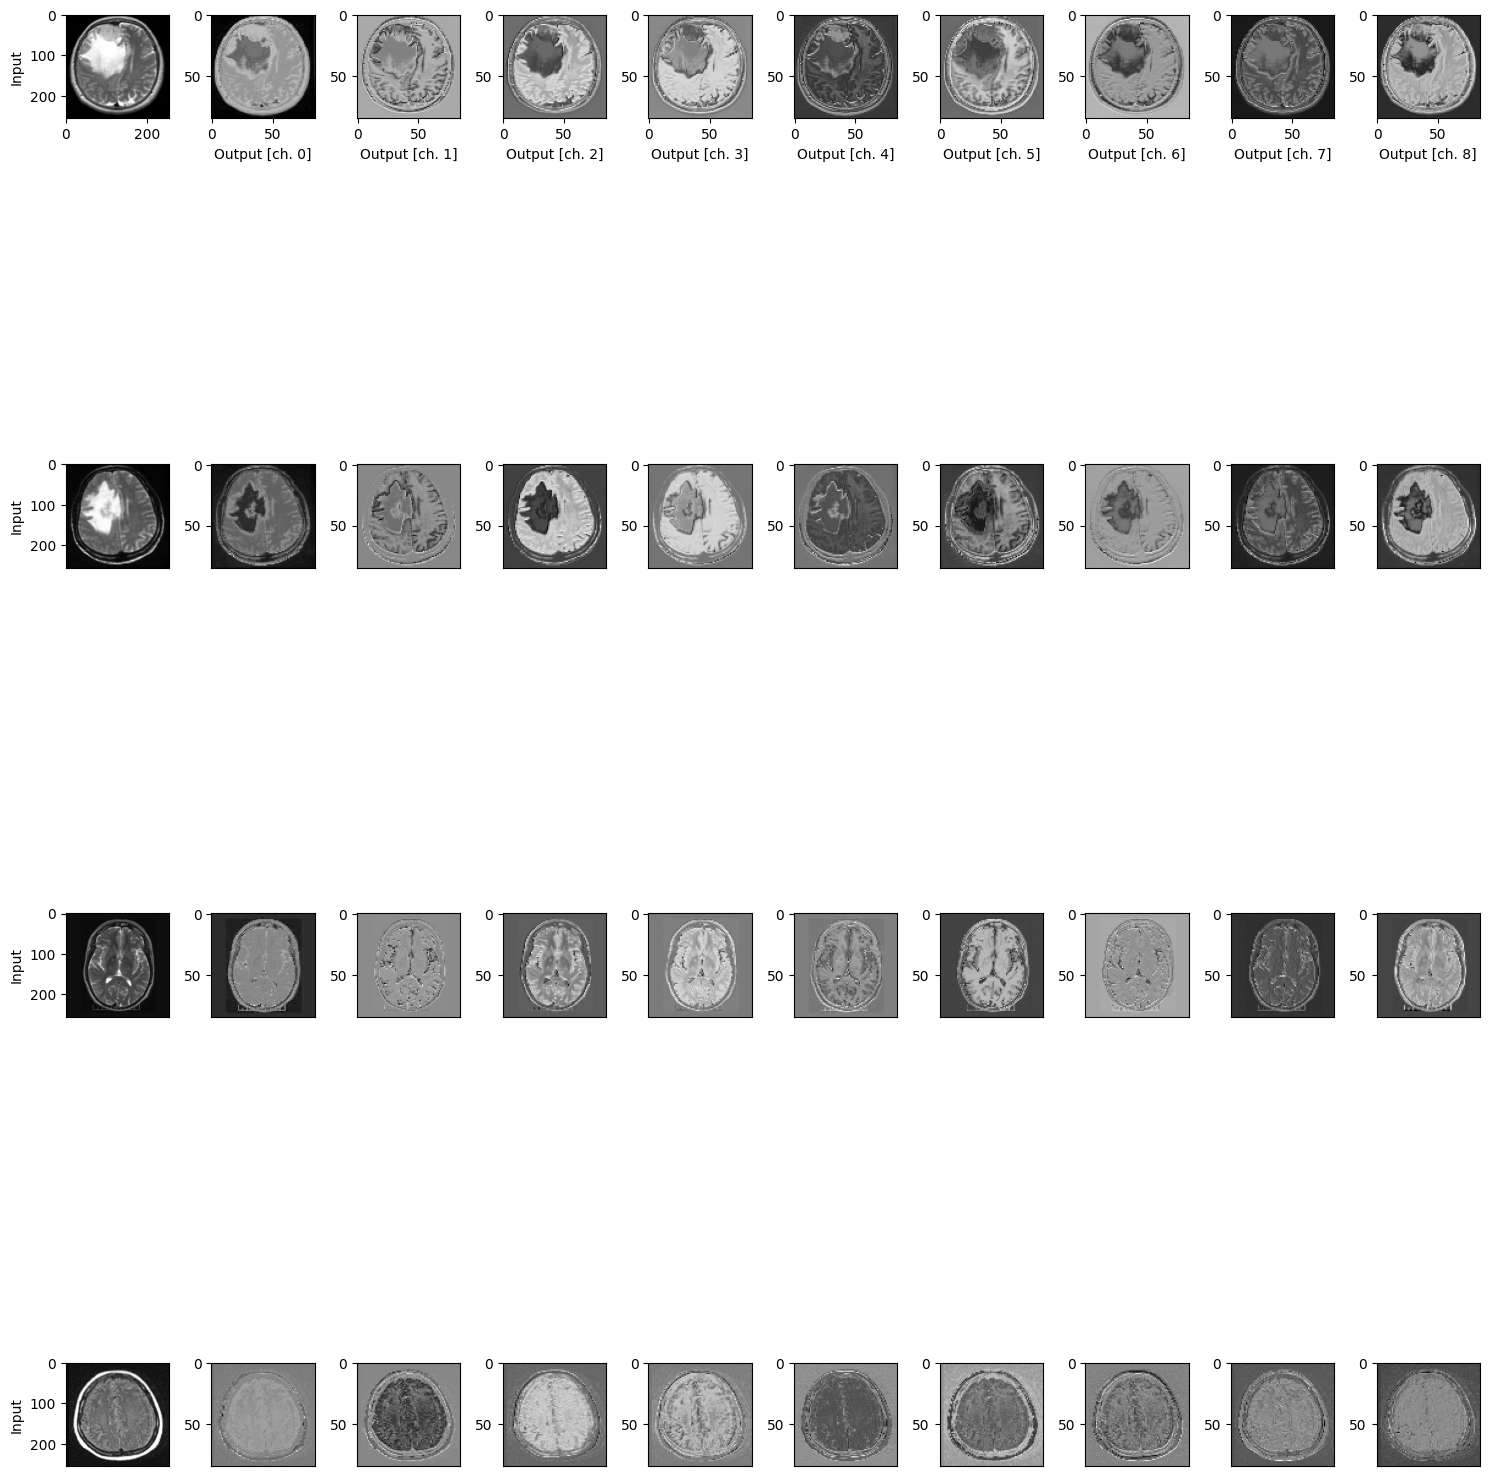

In [ ]:
import matplotlib.pyplot as plt

n_samples = 4
n_channels = 9

fig, axes = plt.subplots(n_samples, 1 + n_channels, figsize=(15, 20))  # Aumenta le dimensioni della figura

for k in range(n_samples):
    axes[k, 0].set_ylabel("Input")
    if k != 0:
        axes[k, 0].xaxis.set_visible(False)  # Nascondi gli assi x
    axes[k, 0].imshow(images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[k, c + 1].set_xlabel("Output [ch. {}]".format(c))  # Etichetta x
        if k != 0:
            axes[k, c + 1].xaxis.set_visible(False)  # Nascondi gli assi x
        axes[k, c + 1].imshow(q_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [ ]:
q_images.shape

(253, 85, 85, 9)

In [ ]:
n_epochs = 20
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

kernel_size = 3

model = Sequential()

model.add(Conv2D(32, (kernel_size, kernel_size), activation='relu', input_shape=(85, 85, 9)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (kernel_size, kernel_size), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (kernel_size, kernel_size), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 83, 83, 32)        2624      
                                                                 
 max_pooling2d (MaxPooling2  (None, 41, 41, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 39, 39, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 19, 19, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 128)         0

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(q_images, labels_np, test_size=0.1, random_state=42)

In [ ]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [ ]:
q_model = model

q_history = q_model.fit(
    train_images,
    train_labels,
    validation_data=(val_images, val_labels),
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/20
6/6 - 12s - loss: 0.6755 - accuracy: 0.6077 - val_loss: 0.6069 - val_accuracy: 0.6522 - 12s/epoch - 2s/step
Epoch 2/20
6/6 - 5s - loss: 0.6246 - accuracy: 0.6298 - val_loss: 0.5401 - val_accuracy: 0.7826 - 5s/epoch - 871ms/step
Epoch 3/20
6/6 - 5s - loss: 0.5903 - accuracy: 0.7182 - val_loss: 0.5153 - val_accuracy: 0.7609 - 5s/epoch - 786ms/step
Epoch 4/20
6/6 - 6s - loss: 0.5358 - accuracy: 0.7514 - val_loss: 0.4857 - val_accuracy: 0.8043 - 6s/epoch - 1s/step
Epoch 5/20
6/6 - 5s - loss: 0.5262 - accuracy: 0.7569 - val_loss: 0.4775 - val_accuracy: 0.8043 - 5s/epoch - 895ms/step
Epoch 6/20
6/6 - 4s - loss: 0.4819 - accuracy: 0.7790 - val_loss: 0.5081 - val_accuracy: 0.7609 - 4s/epoch - 679ms/step
Epoch 7/20
6/6 - 5s - loss: 0.5100 - accuracy: 0.7624 - val_loss: 0.4945 - val_accuracy: 0.7826 - 5s/epoch - 824ms/step
Epoch 8/20
6/6 - 4s - loss: 0.4679 - accuracy: 0.8066 - val_loss: 0.5126 - val_accuracy: 0.7609 - 4s/epoch - 635ms/step
Epoch 9/20
6/6 - 2s - loss: 0.4610 - accurac

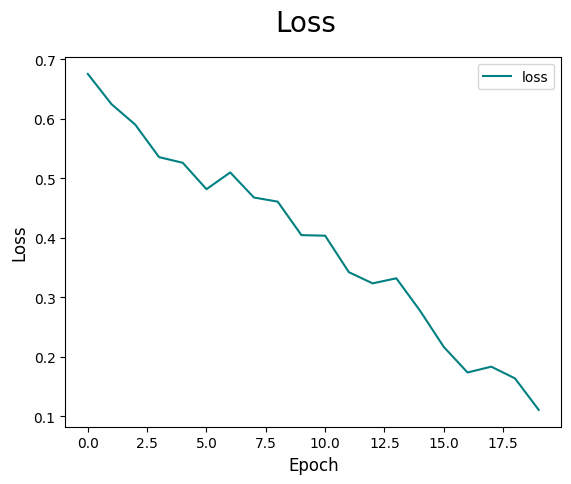

In [ ]:
fig = plt.figure()
plt.plot(q_history.history['loss'], color='teal', label='loss')
fig.suptitle('Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calcolo delle predizioni del modello
y_pred = model.predict(test_images)
y_pred_binary = (y_pred > 0.5).astype(int)  # Considera una soglia di 0.5 per la classificazione binaria

# Calcolo di precision, recall e f1-score
precision = precision_score(test_labels, y_pred_binary)
recall = recall_score(test_labels, y_pred_binary)
f1 = f1_score(test_labels, y_pred_binary)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

1/1 [==============================] - 0s 223ms/step
Precision: 0.8095238095238095
Recall: 1.0
F1-score: 0.8947368421052632


In [ ]:
incorrect_indices = []
for i in range(len(test_labels)):
  if(test_labels[i] != y_pred_binary[i][0]):
    incorrect_indices.append(i)
print(incorrect_indices)

[13, 18, 19, 25]


TypeError: Invalid shape (85, 85, 9) for image data

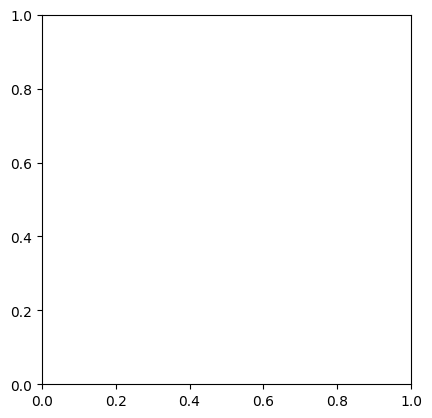

In [ ]:
for idx in incorrect_indices:
    plt.imshow(test_images[idx], cmap='gray')
    plt.title(f"Predicted: {y_pred_binary[idx][0]}, Actual: {test_labels[idx]}")
    plt.show()